
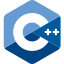
<br>

<div style="text-align:center; font-size:200%;">
  <b>Design Patterns for Testable Code</b>
</div>
<br/>
<div style="text-align:center; font-size:120%;">Dr. Matthias Hölzl</div>
<br/>
<div style="text-align:center;">Coding-Academy Munich</div>
<br/>
<!-- 02 Design Patterns for Testable Code.ipynb -->
<!-- slides/module_410_unit_testing/topic_210_design_patterns_for_tests.cpp -->


## Seams

- Points in the code where we can change behavior for testing without
  modifying the code itself.
- Important for introducing test doubles.
- Examples:
  - Virtual functions/interfaces
  - Template parameters
  - Function pointers
  - Functions from dynamic libraries


## Patterns for Testability

- **Dependency Injection (DI)**
  - Introduces seams by injecting dependencies from the outside.
- **Dependency Inversion Principle (DIP):**
  - Allows controlling the direction of dependencies.
  - Introduces interfaces that improve testability.
- **Humble Object Pattern:**
  - Isolates complex, hard-to-test logic from the outside world.


### Dependency Injection

- A class should not create its own dependencies.
- Instead, they are "injected" from the outside (e.g., via the constructor).

In [ ]:
#include <iostream>
#include <memory>

In [ ]:
class IDependency
{
public:
    virtual ~IDependency() = default;
    virtual void perform_work() const = 0;
};

In [ ]:
class Dependency : public IDependency
{
public:
    void perform_work() const override
    {
        std::cout << "Performing work in Dependency" << std::endl;
    }
};

In [ ]:
class MyClassWithoutDI
{
public:
    MyClassWithoutDI() : dependency{std::make_unique<Dependency>()} {}

    void do_something() const { dependency->perform_work(); }

private:
    std::unique_ptr<IDependency> dependency;
};

In [ ]:
MyClassWithoutDI no_di{};

In [ ]:
no_di.do_something();

In [ ]:
class MyClassWithDI
{
public:
    // MyClassWithDI() : dependency{std::make_unique<Dependency>()} {}
    MyClassWithDI(std::unique_ptr<IDependency> dep) : dependency(std::move(dep)) {}

    void do_something() const { dependency->perform_work(); }

private:
    std::unique_ptr<IDependency> dependency;
};

In [ ]:
MyClassWithDI with_di{std::make_unique<Dependency>()};

In [ ]:
with_di.do_something();


# Dependency Inversion Principle

- The core functionality of a system does not depend on its environment
  - **Concrete artifacts depend on abstractions** (not vice versa)
  - **Unstable artifacts depend on stable artifacts** (not vice versa)
  - **Outer layers** of the architecture **depend on inner layers** (not vice
    versa)
  - Classes/Modules depend on abstractions (e.g., interfaces) not on other
    classes/modules
- Dependency inversion achieves this by introducing interfaces that “reverse
  the dependencies”


## Dependencies

- We have to distinguish two kinds of dependencies:
  - Data and control flow
  - Source code dependencies
- Data and control flow dependencies are inherent in the logic
- Source code dependencies can be controlled by the architecture


The source code dependency goes in the same direction as the data flow:

`MyModule.cpp` ⟹ `Database.h`

<img src="img/db-example-01.svg"
     style="display:block;margin:auto;width:75%"/>


### Before
<img src="img/dependency-01.svg"
     style="display:block;margin:auto;width:75%"/>

### After
<img src="img/dependency-02.svg"
     style="display:block;margin:auto;width:75%"/>


<img src="img/dip-01.svg"
     style="display:block;margin:auto;width:95%"/>


<img src="img/dip-02.svg"
     style="display:block;margin:auto;width:95%"/>


<img src="img/dip-03.svg"
     style="display:block;margin:auto;width:95%"/>


## How DIP and DI work together:

- DIP: abstract interface
- DI: injection of the concrete implementation at runtime

**Effect:** Ability to bring test doubles into play


### Humble Object Pattern

**Problem:**
- How do you test code that is heavily intertwined with "inconvenient"
  infrastructure?
  - UI
  - Database
  - API
  - ...


### Humble Object Pattern

**Solution:** Split the class into two parts:
1.  **The Humble Object:**
    - A very thin wrapper at the boundary to the external system.
    - Contains *no* logic (no `if` statements, loops, etc.).
    - Its only job: shuttle data back and forth.
    - Is so simple that it doesn't need to be tested.

2.  **The Testable Logic:**
    - All the complex code (business logic, decisions).
    - Is extracted into a separate class that has no knowledge of the infrastructure.
    - This class is easily and fully testable.


## Refactoring to a Testable Object

**Goal:** Refactor a hard-to-test class that mixes business logic and
external dependencies using the described patterns.

**Scenario:** An `OrderProcessor` that:

- reads order data from a file,
- calculates discounts and checks inventory,
- saves orders to a database,
- updates inventory.

This is difficult to test because it depends on file system and database.

A starter kit is available in the repository under
`code/starter_kits/order_processor_sk`. A (partial) solution is available
under `code/completed/order_processor`.


## Workshop: Refactoring to a Testable Object

**Goal:** Refactor a hard-to-test class that mixes business logic and external
dependencies using the patterns we discussed.

**Scenario:** A `UserRegistrationService` that:

- reads user data from a file,
- applies validation and business rules,
- saves users to a database,
- sends email notifications.

This is difficult to test because it depends on file system, database, and email
service.


Here is the class we will refactor. Notice how the business logic
is mixed with external dependencies.

A starter kit is available in the repository under
`code/starter_kits/user_registration_sk`.

In [ ]:
#include "check.h"
#include <fstream>
#include <iostream>
#include <sstream>
#include <stdexcept>
#include <string>
#include <vector>

In [ ]:
struct User
{
    std::string name;
    std::string email;
    int age;
    std::string role;
};

In [ ]:
// Original monolithic class - hard to test
class UserRegistrationService
{
public:
    void register_users_from_file(const std::string& file_path)
    {
        // 1. Read from file (infrastructure)
        std::ifstream file(file_path);
        if (!file)
        {
            throw std::runtime_error("Could not open file");
        }

        std::string line;
        while (std::getline(file, line))
        {
            // 2. Parse user data (could be business logic)
            User user = parse_user_line(line);

            // 3. Business logic validation
            if (!is_valid_user(user))
            {
                std::cout << "Invalid user: " << user.name << std::endl;
                continue;
            }

            // 4. Apply business rules
            std::string assigned_role = assign_role(user);
            user.role = assigned_role;

            // 5. Save to database (infrastructure)
            save_to_database(user);

            // 6. Send email (infrastructure)
            send_welcome_email(user);
        }
    }

private:
    User parse_user_line(const std::string& line)
    {
        std::stringstream ss(line);
        std::string name, email, age_str;

        std::getline(ss, name, ',');
        std::getline(ss, email, ',');
        std::getline(ss, age_str, ',');

        return {name, email, std::stoi(age_str), ""};
    }

    // Business logic - should be easily testable
    bool is_valid_user(const User& user)
    {
        return !user.name.empty() && user.email.find('@') != std::string::npos &&
               user.age >= 18 && user.age <= 120;
    }

    // Business logic - should be easily testable
    std::string assign_role(const User& user)
    {
        if (user.age >= 65)
        {
            return "senior";
        }
        if (user.age >= 18)
        {
            return "adult";
        }
        return "minor";
    }

    // Infrastructure - hard to test
    void save_to_database(const User& user)
    {
        std::cout << "Saving to DB: " << user.name << std::endl;
        // Simulate database save
    }

    // Infrastructure - hard to test
    void send_welcome_email(const User& user)
    {
        std::cout << "Sending email to: " << user.email << std::endl;
        // Simulate email sending
    }
};

In [ ]:
void demonstrate_user_registration_service()
{
    UserRegistrationService service;
    try
    {
        service.register_users_from_file("users.txt");
    }
    catch (const std::runtime_error& e)
    {
        std::cerr << "Error: " << e.what() << std::endl;
    }
}

In [ ]:
demonstrate_user_registration_service();


### Your Task: Refactor & Test

1.  **Extract the Business Logic:** Create a `UserProcessor` class that encapsulates
the pure business logic (validation, role assignment).
2.  **Create the Humble Object:** The original `UserRegistrationService` becomes
the Humble Object. It only handles I/O and delegates business logic.
3.  **Abstract the Infrastructure:** Use interfaces for database and email service
to improve testability.
4.  **Write Tests:** Write unit tests for the `UserProcessor` class.

In [ ]:
// Solution:
namespace humble_object_solution
{

// Interfaces for external dependencies
class IUserRepository
{
public:
    virtual ~IUserRepository() = default;
    virtual void save(const User& user) = 0;
};

class IEmailService
{
public:
    virtual ~IEmailService() = default;
    virtual void send_welcome_email(const User& user) = 0;
};

// 1. Pure business logic - easily testable
class UserProcessor
{
public:
    struct ProcessingResult
    {
        bool is_valid;
        User processed_user;
        std::string error_message;
    };

    ProcessingResult process_user(const User& user)
    {
        ProcessingResult result;
        result.processed_user = user;

        // Validation business logic
        if (!is_valid_user(user))
        {
            result.is_valid = false;
            result.error_message = "Invalid user data";
            return result;
        }

        // Business rules
        result.processed_user.role = assign_role(user);
        result.is_valid = true;
        return result;
    }

    // Now these methods are easily testable
    bool is_valid_user(const User& user)
    {
        return !user.name.empty() && user.email.find('@') != std::string::npos &&
               user.age >= 18 && user.age <= 120;
    }

    std::string assign_role(const User& user)
    {
        if (user.age >= 65)
        {
            return "senior";
        }
        if (user.age >= 18)
        {
            return "adult";
        }
        return "minor";
    }
};

// 2. Humble Object - only handles infrastructure
class UserRegistrationService
{
private:
    UserProcessor processor;
    IUserRepository* repository;
    IEmailService* email_service;

public:
    UserRegistrationService(IUserRepository* repo, IEmailService* email)
        : repository(repo), email_service(email)
    {}

    void register_users_from_file(const std::string& file_path)
    {
        // Only handles file I/O
        std::ifstream file(file_path);
        if (!file)
        {
            throw std::runtime_error("Could not open file");
        }

        std::string line;
        while (std::getline(file, line))
        {
            User user = parse_user_line(line);

            // Delegate to business logic
            auto result = processor.process_user(user);

            if (!result.is_valid)
            {
                std::cout << "Invalid user (" << result.processed_user.name
                          << "): " << result.error_message << std::endl;
                continue;
            }

            // Handle infrastructure
            repository->save(result.processed_user);
            email_service->send_welcome_email(result.processed_user);
        }
    }

private:
    User parse_user_line(const std::string& line)
    {
        std::stringstream ss(line);
        std::string name, email, age_str;

        std::getline(ss, name, ',');
        std::getline(ss, email, ',');
        std::getline(ss, age_str, ',');

        return {name, email, std::stoi(age_str), ""};
    }
};

// 3. Test implementations
class MockUserRepository : public IUserRepository
{
public:
    std::vector<User> saved_users;

    void save(const User& user) override { saved_users.push_back(user); }
};

class MockEmailService : public IEmailService
{
public:
    std::vector<std::string> sent_emails;

    void send_welcome_email(const User& user) override
    {
        sent_emails.push_back(user.email);
    }
};

// 4. Unit tests for pure business logic
void test_user_processor()
{
    UserProcessor processor;

    // Test valid user
    User valid_user{"John Doe", "john@example.com", 30, ""};
    auto result = processor.process_user(valid_user);

    check(result.is_valid, "Valid user should be processed successfully");
    check(result.processed_user.role == "adult", "30-year-old should get 'adult' role");

    // Test invalid user
    User invalid_user{"", "invalid-email", 17, ""};
    auto invalid_result = processor.process_user(invalid_user);

    check(!invalid_result.is_valid, "Invalid user should be rejected");

    // Test senior user
    User senior_user{"Jane Smith", "jane@example.com", 70, ""};
    auto senior_result = processor.process_user(senior_user);

    check(senior_result.is_valid, "Senior user should be valid");
    check(
        senior_result.processed_user.role == "senior",
        "70-year-old should get 'senior' role"
    );

    std::cout << "All UserProcessor tests passed!" << std::endl;
}

// 5. Integration test demonstrating the pattern
void test_integration()
{
    MockUserRepository mock_repo;
    MockEmailService mock_email;

    UserRegistrationService service(&mock_repo, &mock_email);

    // This would normally read from file, but for demo we can test the components
    UserProcessor processor;
    User test_user{"Alice Johnson", "alice@example.com", 25, ""};

    auto result = processor.process_user(test_user);
    if (result.is_valid)
    {
        mock_repo.save(result.processed_user);
        mock_email.send_welcome_email(result.processed_user);
    }

    check(mock_repo.saved_users.size() == 1, "User should be saved");
    check(mock_email.sent_emails.size() == 1, "Email should be sent");
    check(mock_repo.saved_users[0].role == "adult", "Role should be assigned");

    std::cout << "Integration test passed!" << std::endl;
}

// Demonstration function
class DemoUserRepository : public IUserRepository
{
public:
    void save(const User& user) override
    {
        std::cout << "Saving user to database: " << user.name << std::endl;
        // Simulate database save
    }
};

class DemoEmailService : public IEmailService
{
public:
    void send_welcome_email(const User& user) override
    {
        std::cout << "Sending welcome email to: " << user.email << std::endl;
        // Simulate email sending
    }
};

void demonstrate_humble_object_solution()
{
    // Create services
    DemoUserRepository user_repository;
    DemoEmailService email_service;

    // Create the humble object
    UserRegistrationService service(&user_repository, &email_service);

    // Process users from a file (simulated)
    try
    {
        service.register_users_from_file("users.txt");
    }
    catch (const std::runtime_error& e)
    {
        std::cerr << "Error: " << e.what() << std::endl;
    }
}

} // namespace humble_object_solution

In [ ]:
humble_object_solution::test_user_processor();

In [ ]:
humble_object_solution::test_integration();

In [ ]:
humble_object_solution::demonstrate_humble_object_solution();